In [1]:
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
import csv
import itertools
%matplotlib inline

In [2]:
network_file, _ = urlretrieve('https://gist.githubusercontent.com/cchio/82e3e2a618cb2d989f28a5d549c8c967/raw/6f13e84f9fb3e87e15c873d125084af0854e35b0/trimmed_btc_alpha_otc.csv')
network_validation_file, _ = urlretrieve('https://gist.githubusercontent.com/cchio/4f5e8995e995a2040c0b19228acc6638/raw/4a8ee8cdfed531e3456e7b1f759dccd6fbca4b88/trimmed_btc_alpha_otc_validation.csv')

In [3]:
trim_network = pd.read_csv(network_file)

In [4]:
trim_network.head()

,SOURCE,TARGET,RATING,TIMESTAMP,EPISODE
0,35,3952,1,1.365623e+09,21958
1,2125,5379,-1,1.392045e+09,32086
2,5227,5854,1,1.417038e+09,35751
3,6013,13492,-1,1.393304e+09,32395
4,6013,13495,-1,1.392008e+09,32075


In [5]:
def GetNodeFeatures(GDF,n):
    if n==0:
        return ['in_degree','pos_in_edges','neg_in_edges','out_degree','pos_out_edges','neg_out_edges']
    # Get sub-dataframes
    outgoing = GDF[GDF['SOURCE']==n].copy().reset_index(drop=True)
    incoming = GDF[GDF['TARGET']==n].copy().reset_index(drop=True)
    
    # Compute node degree (incoming)
    in_degree = len(incoming)
    
    # Compute node degree (outgoing)
    out_degree = len(outgoing)
    
    # Compute number of incoming nodes with positive ratings
    pos_in_edges = len([i for i in incoming.RATING.values if i>0])
    
    # Computer number of incoming nodes with negative ratings
    neg_in_edges = len([i for i in incoming.RATING.values if i<0])
    
    # Repeat for outgoing edges
    pos_out_edges = len([i for i in outgoing.RATING.values if i>0])
    
    # Computer number of incoming nodes with negative ratings
    neg_out_edges = len([i for i in outgoing.RATING.values if i<0])
    
    return np.array([in_degree,pos_in_edges,neg_in_edges,out_degree,pos_out_edges,neg_out_edges])

In [6]:
# Define list of nodes and sort it in ascending order
nodes = list( set(trim_network['SOURCE']) | set(trim_network['TARGET']) )
nodes.sort()

# Create NF, the node feature matrix
NF = np.zeros([len(nodes),6])
for i,n in enumerate(nodes):
    NF[i,:] = np.array(GetNodeFeatures(trim_network,n))
    
# Create a dataframe containing all these node features
NF_df = pd.DataFrame(columns=GetNodeFeatures(trim_network,0),data=NF,index=nodes)

In [7]:
NF_df.head()

,in_degree,pos_in_edges,neg_in_edges,out_degree,pos_out_edges,neg_out_edges
1,198.0,198.0,0.0,184.0,177.0,7.0
2,36.0,35.0,1.0,36.0,34.0,2.0
3,20.0,11.0,9.0,0.0,0.0,0.0
4,40.0,40.0,0.0,52.0,49.0,3.0
5,3.0,3.0,0.0,2.0,2.0,0.0


In [8]:
f = open('trimmed_network.edgelist','w')
for i in range(len(trim_network)):
    s = str(trim_network['SOURCE'][i])
    t = str(trim_network['TARGET'][i])
    f.write(s+' '+t+'\n')
f.close()

In [9]:
# python ./node2vec/src/main.py --input ./trimmed_network.edgelist --output ./trimmed_network.emb --dimensions 14 --num-walks 25 --iter 15

In [10]:
emb, _ = urlretrieve('https://gist.githubusercontent.com/cchio/aff8e650135aabfdbc8061c70215e36b/raw/e744ba8e53217595c6e9da0222a6803de1dece2d/trimmed_network.emb')

In [11]:
n = []
e = []
with open(emb) as fin:
    for line in fin:
        node_emb = line.strip().split()
        n.append(node_emb[0])
        e.append(node_emb[1:])
n = n[1:]
n = [int(i) for i in n]
embs = np.zeros([len(e)-1,14])
for i in range(1,len(e)):
    embs[i-1] = e[i]
embs.shape

(9664, 14)

In [12]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
proj = tsne.fit_transform(embs)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [13]:
alpha_nodes = []
otc_nodes = []
for i in range(len(n)):
    if n[i] > 6005: # The highest OTC node ID is 6005
        alpha_nodes.append(i)
    else:
        otc_nodes.append(i)

Text(0.5, 1.0, '2-dimensional mapping with t-SNE of Bitcoin network nodes with Node2Vec')

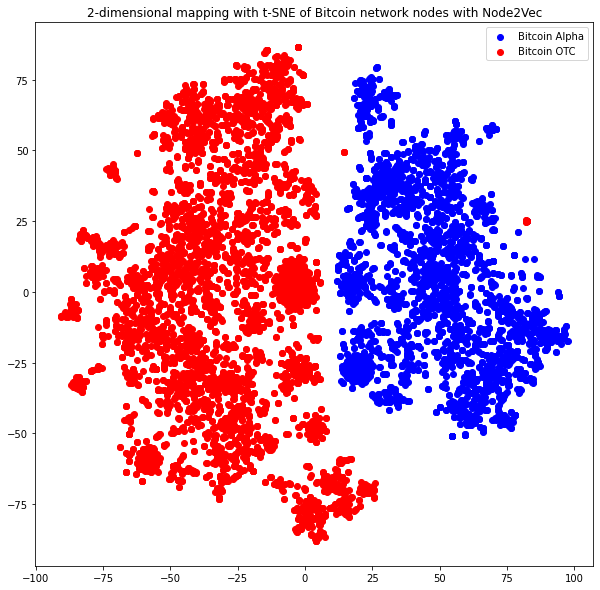

In [14]:
plt.figure(figsize=(10,10))
alpha = proj[alpha_nodes,:]
otc = proj[otc_nodes,:]
plt.scatter(alpha[:,0],alpha[:,1],c='b',label='Bitcoin Alpha')
plt.scatter(otc[:,0],otc[:,1],c='r',label='Bitcoin OTC')
plt.legend()
plt.title('2-dimensional mapping with t-SNE of Bitcoin network nodes with Node2Vec')

In [15]:
NF_matrix = np.zeros([len(n),20]) # Recall that we have 14 Node2Vec features plus 6 features extracted from the rating network
for i in range(len(n)):
    NF_matrix[i] = np.concatenate([embs[i],np.log2(NF_df.loc[n[i]].values + 1)])
NF_matrix.shape

(9664, 20)

In [16]:
NF_matrix_mean = np.mean(NF_matrix,axis=0)
NF_matrix_std = np.std(NF_matrix,axis=0)
NF_matrix_norm = ( NF_matrix - NF_matrix_mean ) / ( NF_matrix_std )

In [17]:
emb_df_norm = pd.DataFrame(columns=list(range(1,21)),index=n,data=NF_matrix_norm)
emb_df_norm.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
35,-1.774256,-0.448314,0.047397,0.612565,0.797896,-0.789905,-0.051981,-0.121641,-0.866701,0.772711,-0.960294,-0.634862,-0.391693,0.070921,5.995989,5.966601,-0.403738,5.764529,5.928494,5.244485
6006,-0.501574,-0.084692,0.723285,-1.407241,-0.649710,1.117009,0.567946,0.082475,-0.241229,-1.279825,0.483483,-0.937666,-1.084376,0.990163,5.628302,5.607510,-0.403738,5.253367,5.415542,2.245152
2642,-1.139167,-0.513084,1.118884,0.059454,-0.080315,-0.162173,0.315040,0.686051,0.649060,1.255844,-0.181627,0.228191,0.024559,-0.302619,5.577683,5.554465,1.132302,5.057479,5.198008,4.509349
2125,0.168152,0.876179,-0.513470,-0.215777,-0.248220,-0.916373,-0.365312,0.893897,0.826803,0.918575,-0.683717,1.040111,1.754360,-0.239251,4.613721,4.616648,-0.403738,5.057479,4.230008,12.063567
1810,0.072147,0.400560,0.326883,-0.186649,1.174607,-0.715021,-0.125926,1.679218,-0.296529,0.525661,-0.017292,0.255513,0.899269,0.118267,5.310770,5.124245,7.598189,5.026762,4.650978,11.015487


In [18]:
X = np.zeros([len(trim_network),40])
y = np.zeros(len(trim_network))
for i in range(len(trim_network)):
    s = trim_network['SOURCE'][i]
    t = trim_network['TARGET'][i]
    r = trim_network['RATING'][i]
    left = emb_df_norm.loc[s,:].values
    right = emb_df_norm.loc[t,:].values
    X[i,:] = np.concatenate([left,right])
    if r>0:
        y[i] = 0 # If not fraud
    else:
        y[i] = 1 # If fraud

In [19]:
val_network = pd.read_csv(network_validation_file)
X_val = np.zeros([len(val_network),40])
y_val = np.zeros(len(val_network))
for i in range(len(val_network)):
    s = val_network['SOURCE'][i]
    t = val_network['TARGET'][i]
    r = val_network['RATING'][i]
    left = emb_df_norm.loc[s,:].values
    right = emb_df_norm.loc[t,:].values
    X_val[i,:] = np.concatenate([left,right])
    if r>0:
        y_val[i] = 0 # If not fraud
    else:
        y_val[i] = 1 # If fraud (class imbalance)

In [20]:
# Training the model

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils
from keras.layers.merge import Concatenate

In [22]:
# Create train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

In [24]:
# initialize model

input_size = 40 # Features from X matrix

M1 = Sequential()

# Add an input layer
M1.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M1.add(Dense(128, activation='relu'))

# Add second hidden layer
M1.add(Dense(64, activation='relu'))

#Add third hidden layer
M1.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M1.add(Dense(16, activation='relu'))

# Add output layer
M1.add(Dense(1,activation='sigmoid'))

# Define optimizers
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

M1.compile(loss='binary_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

# Define parameters
Nepochs = 10

AttributeError: ignored

In [ ]:
def sample_dataset(frac=0.8):
    fraud_indices = np.array([i for i in range(len(y_train)) if y_train[i]==1])
    not_fraud_indices = np.array([i for i in range(len(y_train)) if y_train[i]==0])
    sample_size = int(np.round( len(fraud_indices) * frac ))
    fraud_sample = np.random.randint(0,len(fraud_indices),sample_size) 
    not_fraud_sample = np.random.randint(0,len(not_fraud_indices),sample_size)
    y_sample = np.concatenate([y_train[fraud_indices][fraud_sample],y_train[not_fraud_indices[not_fraud_sample]]])
    x_sample = np.concatenate([x_train[fraud_indices][fraud_sample],x_train[not_fraud_indices[not_fraud_sample]]])
    return x_sample,y_sample

In [ ]:
for i in range(15):
    sample_x, sample_y = sample_dataset()
    M1.fit(sample_x, sample_y, epochs=Nepochs, batch_size=5, verbose=0)

In [ ]:
y_pred = M1.predict(x_test)

# Print classfication report
target_names = ['Honest','Fraudulent']
confusion_matrix = cm(y_test, np.round(y_pred))
print("Classification Report for TrustKeeper")
print(classification_report(y_test, np.round(y_pred)))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
# What if we don't use the node2vec features?
cols_to_keep = list(range(14,20)) + list(range(34,40))

In [ ]:
# Initialize model

input_size = 12 # Features from X matrix (only the perception scores)

M2 = Sequential()

# Add an input layer
M2.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M2.add(Dense(128, activation='relu'))

# Add second hidden layer
M2.add(Dense(64, activation='relu'))

#Add third hidden layer
M2.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M2.add(Dense(16, activation='relu'))

# Add output layer
M2.add(Dense(1,activation='sigmoid'))

# Define optimizers
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

M2.compile(loss='binary_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

# Define parameters
Nepochs = 10

In [ ]:
for i in range(15):
    sample_x,sample_y = sample_dataset()
    M2.fit(sample_x[:,cols_to_keep], sample_y, epochs=Nepochs, batch_size=5, verbose=0)

In [ ]:
y_pred = M2.predict(x_test[:,cols_to_keep])

# Print classfication report
target_names = ['Honest','Fraudulent']
confusion_matrix = cm(y_test, np.round(y_pred))
print("Classification Report for Model 2 (NN w/o Node2Vec)")
print(classification_report(y_test, np.round(y_pred)))

In [ ]:
# Plot normalized confusion matrix
print('Model 2')
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix (Validation)')